<a href="https://colab.research.google.com/github/dasamitansu159/Physic-Informed-Neural-Networks/blob/main/Heat_Diffusion_equation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tf_silent
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from pinn import PINN
from network import Network
from optimizer import L_BFGS_B
from numpy import linalg as LA
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.colors as colors

In [ ]:
def u0(tx):
    """
    equation of our initial condition
    tx is the tensorflow vector containing the value of t and x"""

    t = tx[:,0, None]
    x = tx[:,1, None]

    return x**2*(2-x)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 32)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

Optimizer: L-BFGS-B (maxiter=10000)
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 97s 10ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


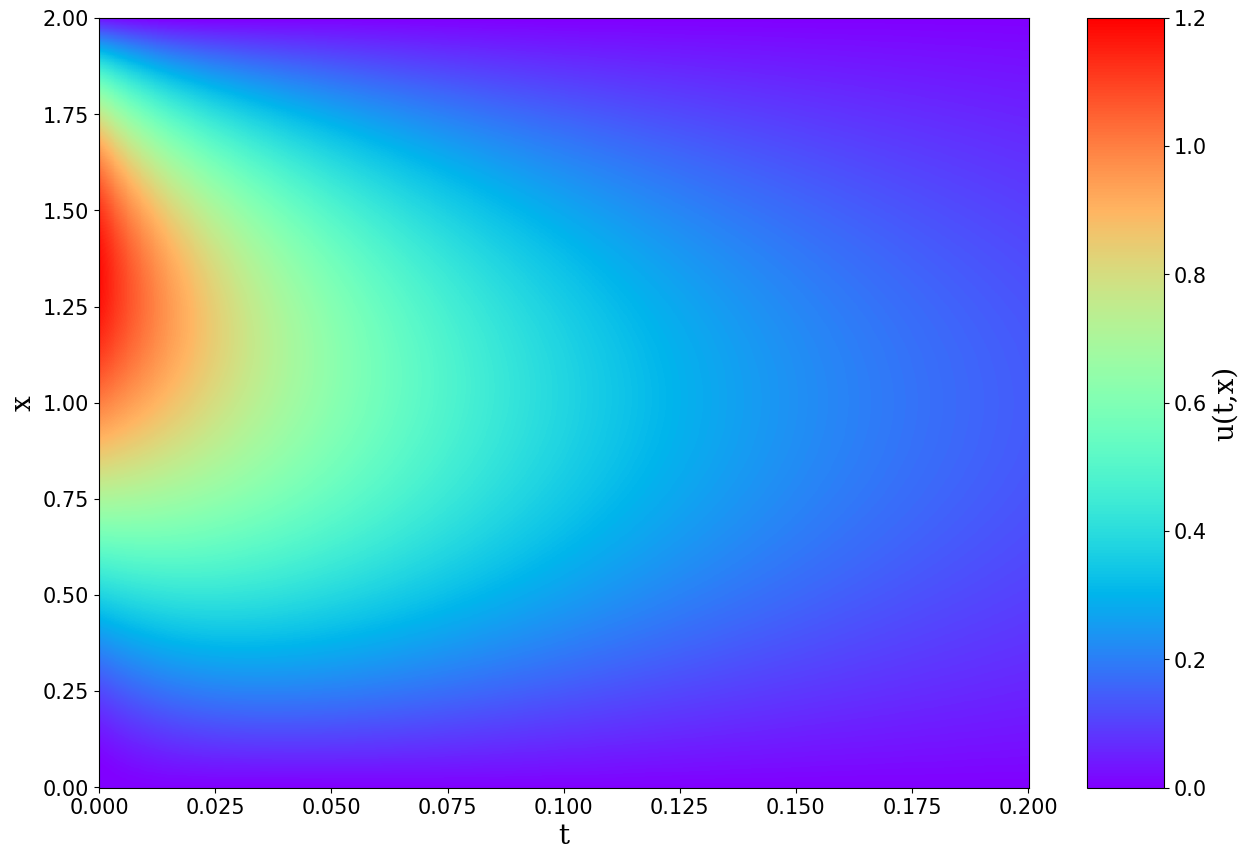

In [ ]:
if  __name__ == "__main__":
    num_train_samples = 50
    num_test_samples = 1000

    network = Network.build()
    network.summary()

    pinn = PINN(network).build()

    ## Time and space domain
    t_f = 0.2
    x_f = 2
    x_ini = 0


    # create the training input
    tx_eqn = np.random.rand(num_train_samples, 2)
    tx_eqn[..., 0] = t_f*tx_eqn[..., 0]
    tx_eqn[..., 1] = (x_f-x_ini)*tx_eqn[..., 1] + x_ini
    tx_ini = np.random.rand(num_train_samples, 2)
    tx_ini[..., 0] = 0
    tx_ini[..., 1] = (x_f-x_ini)*tx_ini[..., 1] + x_ini
    tx_bnd_up = np.random.rand(num_train_samples, 2)
    tx_bnd_up[..., 0] = t_f*tx_bnd_up[..., 0]
    tx_bnd_up[..., 1] = x_f  # x = -1 or +1
    tx_bnd_down = np.random.rand(num_train_samples, 2)
    tx_bnd_down[..., 0] = t_f*tx_bnd_down[..., 0]
    tx_bnd_down[..., 1] = x_ini

    # creating the training output
    u_zero = np.zeros((num_train_samples, 1))
    u_ini = u0(tf.constant(tx_ini)).numpy()

    # train the model using L-BFGS-B algorithm
    x_train = [tx_eqn, tx_ini, tx_bnd_up,tx_bnd_down]
    y_train = [u_zero, u_ini, u_zero, u_zero]
    lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
    lbfgs.fit()

    # predicting  u(t,x) distribution
    t_flat = np.linspace(0, t_f, num_test_samples)
    x_flat = np.linspace(x_ini, x_f, num_test_samples)
    t, x = np.meshgrid(t_flat, x_flat)
    tx = np.stack([t.flatten(), x.flatten()], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    u = u.reshape(t.shape)


    # plot u(t,x) distribution in color-map
    fig = plt.figure(figsize=(15,10))
    vmin, vmax = 0, +1.2
    font1 = {'family':'serif','size':20}
    font2 = {'family':'serif','size':15}
    plt.pcolormesh(t, x, u, cmap='rainbow', norm=Normalize(vmin=vmin, vmax=vmax))
    plt.xlabel('t', fontdict = font1)
    plt.ylabel('x', fontdict = font1)
    plt.tick_params(axis='both', which='major', labelsize=15)
    cbar = plt.colorbar(pad=0.05, aspect=10)
    cbar.set_label('u(t,x)', fontdict = font1)
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)

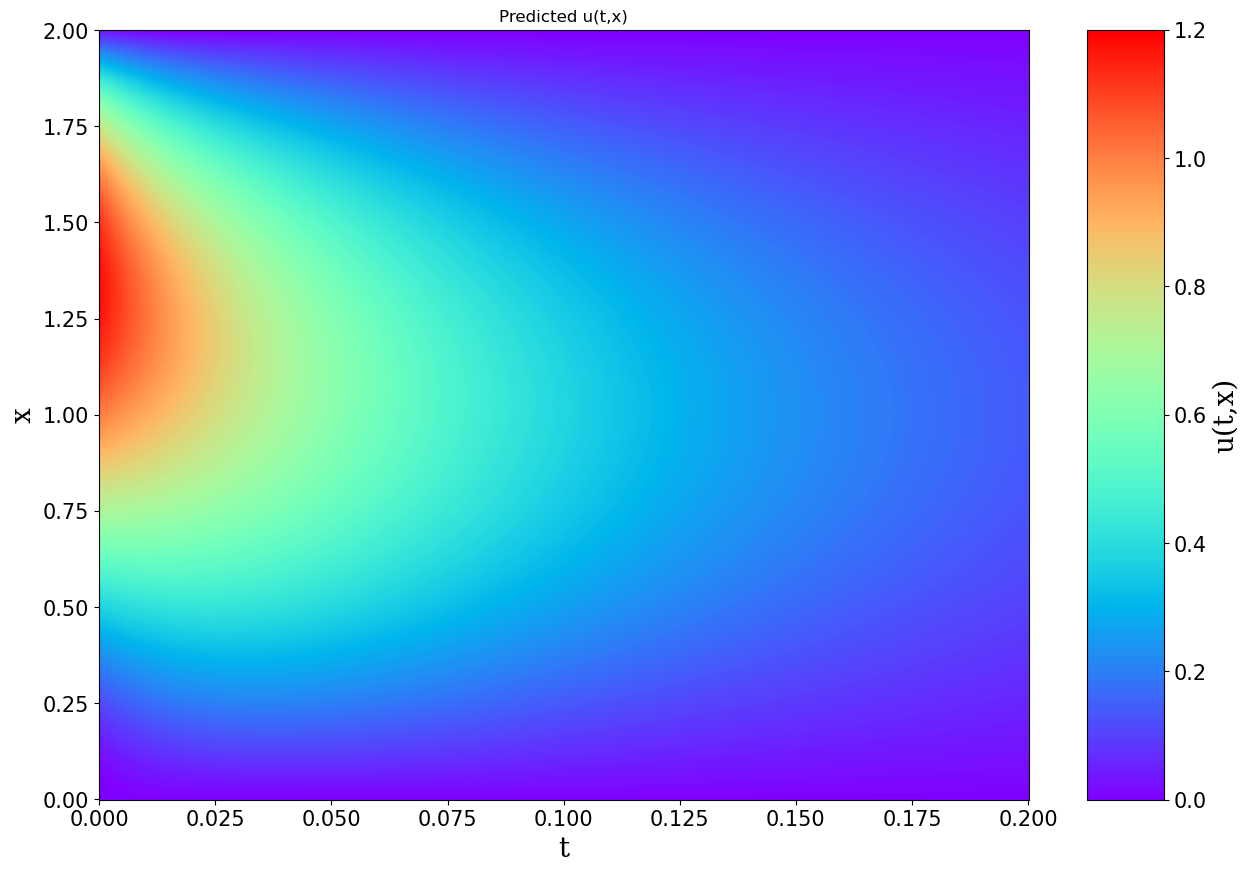

In [ ]:
    # plot u(t,x) distribution in color-map
    fig = plt.figure(figsize=(15,10))
    vmin, vmax = 0, +1.2
    font1 = {'family':'serif','size':20}
    font2 = {'family':'serif','size':15}
    plt.pcolormesh(t, x, u, cmap='rainbow', norm=Normalize(vmin=vmin, vmax=vmax))
    plt.xlabel('t', fontdict = font1)
    plt.ylabel('x', fontdict = font1)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.title("Predicted u(t,x)")
    cbar = plt.colorbar(pad=0.05, aspect=10)
    cbar.set_label('u(t,x)', fontdict = font1)
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)

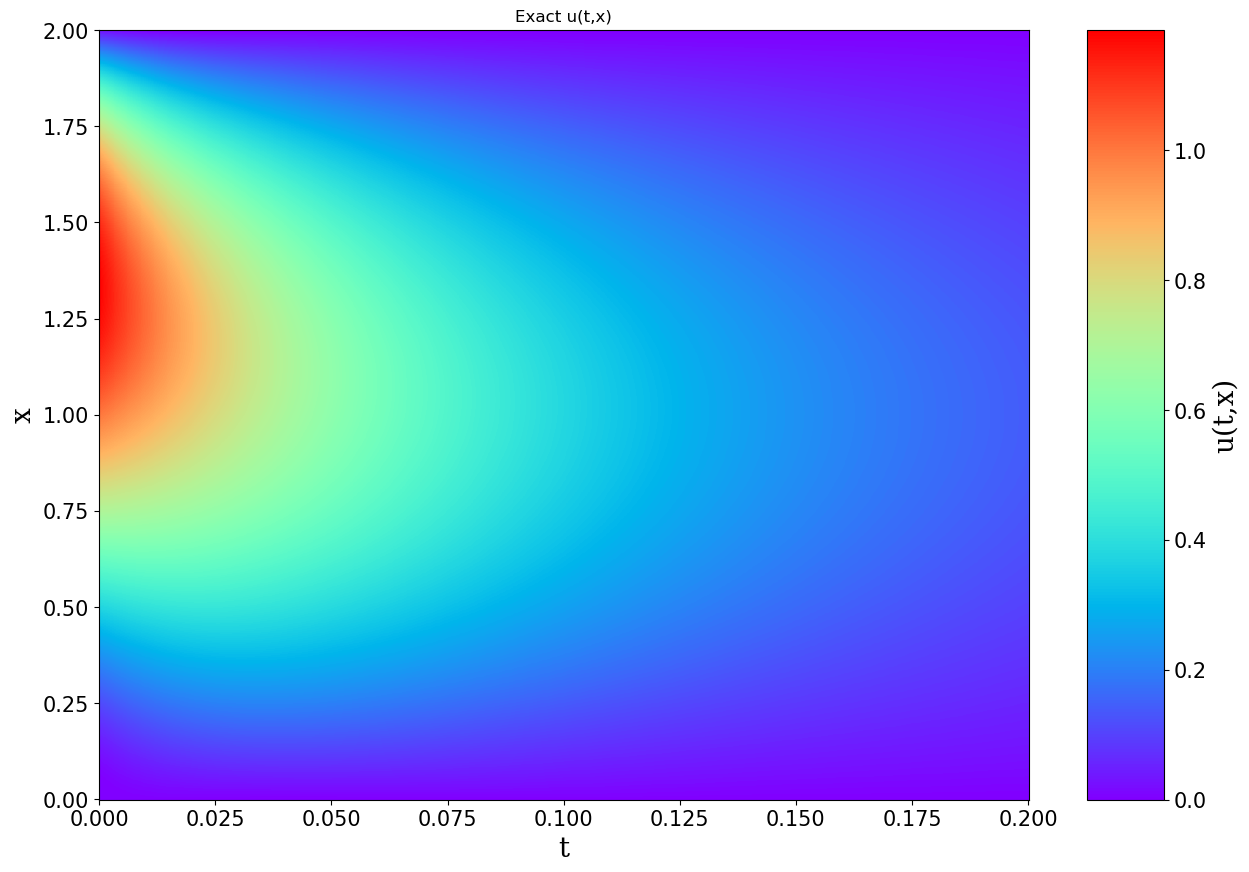

In [ ]:
    # Exact solution U and Error E
    n = num_test_samples
    U = np.zeros([n,n])
    t = np.linspace(0,t_f,n)
    x = np.linspace(x_ini,x_f,n)
    X,T = np.meshgrid(t,x)

    for i in range(1,1000):
      C = -32/(i**3*np.pi**3)*(2*(-1)**i+1)
      for j in range(n):
        U[j,...] = U[j,...] + C*np.sin(i*np.pi*x[j]/2)*np.exp(-i**2*np.pi**2*t)

    fig= plt.figure(figsize=(15,10))
    vmin, vmax = 0, np.max(np.max(U))
    plt.pcolormesh(t, x, u, cmap='rainbow', norm=Normalize(vmin=vmin, vmax=vmax))
    plt.xlabel('t', fontdict = font1)
    plt.ylabel('x', fontdict = font1)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.title("Exact u(t,x)")
    cbar = plt.colorbar(pad=0.05, aspect=10)
    cbar.set_label('u(t,x)', fontdict = font1)
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)

Absolute error: 0.0037839566237582232


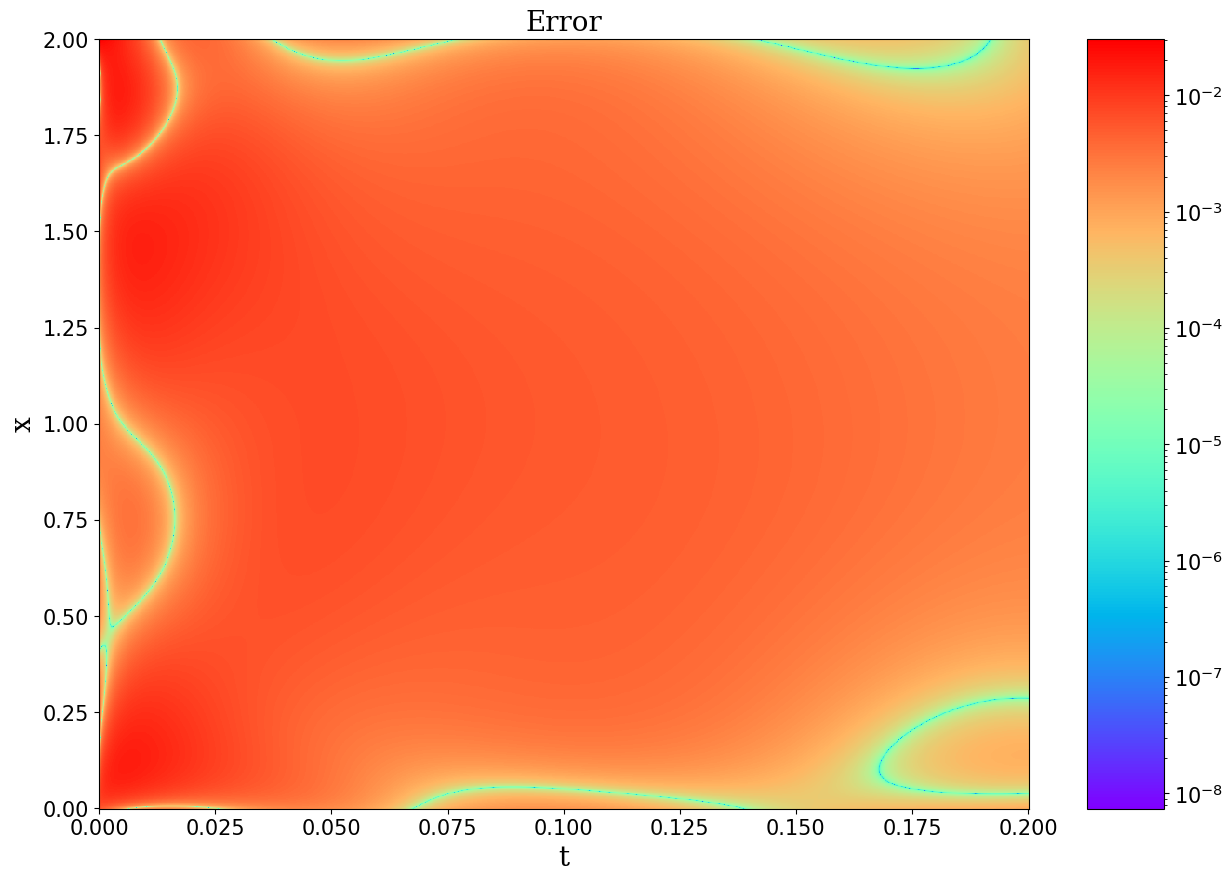

In [ ]:
    # Exact solution U and Error E
    n = num_test_samples
    U = np.zeros([n,n])
    t = np.linspace(0,t_f,n)
    x = np.linspace(x_ini,x_f,n)
    X,T = np.meshgrid(t,x)

    for i in range(1,1000):
      C = -32/(i**3*np.pi**3)*(2*(-1)**i+1)
      for j in range(n):
        U[j,...] = U[j,...] + C*np.sin(i*np.pi*x[j]/2)*np.exp(-i**2*np.pi**2*t)

    E = (U-u)
    print(f"Absolute error: {np.mean(E)}")
    fig= plt.figure(figsize=(15,10))
    vmin, vmax = -np.max(np.max(np.abs(E))), np.max(np.max(np.abs(E)))
    plt.pcolormesh(t, x, abs(E), cmap='rainbow', norm = colors.LogNorm())
    font1 = {'family':'serif','size':20}
    font2 = {'family':'serif','size':15}
    plt.title("Error", fontdict = font1)
    plt.xlabel("t", fontdict = font1)
    plt.ylabel("x", fontdict = font1)
    plt.tick_params(axis='both', which='major', labelsize=15)
    cbar = plt.colorbar(pad=0.05, aspect=10)
    cbar.ax.tick_params(labelsize=15)
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


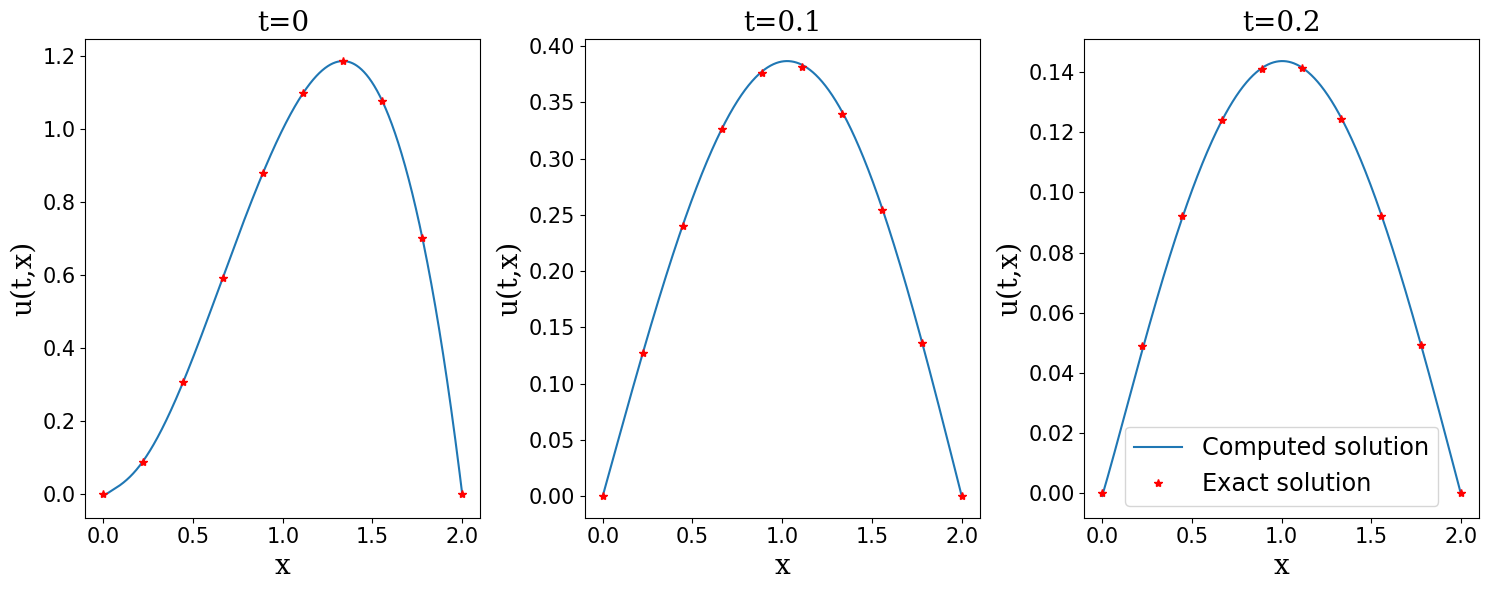

In [ ]:
    # Comparison at time 0, 0.1 and 0.2

    fig,(ax1, ax2, ax3)  = plt.subplots(1,3,figsize=(15,6))
    x_flat_ = np.linspace(x_ini, x_f, 10)

    font1 = {'family':'serif','size':20}
    font2 = {'family':'serif','size':15}

    U_1 = np.linspace(0,0,10)
    t = 0

    for i in range(1,500):
      C = -32/(i**3*np.pi**3)*(2*(-1)**i+1)
      U_1 = U_1 + C*np.sin(i*np.pi*x_flat_/2)*np.exp(-i**2*np.pi**2*t)

    tx = np.stack([np.full(t_flat.shape, 0), x_flat], axis=-1)
    u_ = network.predict(tx, batch_size=num_test_samples)
    ax1.plot(x_flat, u_)
    ax1.plot(x_flat_, U_1,'r*')
    ax1.set_title('t={}'.format(0), fontdict = font1)
    ax1.set_xlabel('x', fontdict = font1)
    ax1.set_ylabel('u(t,x)', fontdict = font1)
    ax1.tick_params(labelsize=15)


    U_1 = np.linspace(0,0,10)
    t = 0.1

    for i in range(1,500):
      C = -32/(i**3*np.pi**3)*(2*(-1)**i+1)
      U_1 = U_1 + C*np.sin(i*np.pi*x_flat_/2)*np.exp(-i**2*np.pi**2*t)

    tx = np.stack([np.full(t_flat.shape, 0.1), x_flat], axis=-1)
    u_ = network.predict(tx, batch_size=num_test_samples)
    ax2.plot(x_flat, u_)
    ax2.plot(x_flat_, U_1,'r*')
    ax2.set_title('t={}'.format(0.1), fontdict = font1)
    ax2.set_xlabel('x', fontdict = font1)
    ax2.set_ylabel('u(t,x)', fontdict = font1)
    ax2.tick_params(labelsize=15)


    U_1 = np.linspace(0,0,10)
    t = 0.2

    for i in range(1,500):
      C = -32/(i**3*np.pi**3)*(2*(-1)**i+1)
      U_1 = U_1 + C*np.sin(i*np.pi*x_flat_/2)*np.exp(-i**2*np.pi**2*t)

    tx = np.stack([np.full(t_flat.shape, 0.2), x_flat], axis=-1)
    u_ = network.predict(tx, batch_size=num_test_samples)
    ax3.plot(x_flat, u_,label='Computed solution')
    ax3.plot(x_flat_, U_1,'r*',label='Exact solution')
    ax3.set_title('t={}'.format(0.2), fontdict = font1)
    ax3.set_xlabel('x', fontdict = font1)
    ax3.set_ylabel('u(t,x)', fontdict = font1)
    ax3.legend(loc='best', fontsize = 'xx-large')
    ax3.tick_params(labelsize=15)

    plt.tight_layout()
    plt.show()